In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_score, classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [19]:
data = pd.read_csv('data/Training.csv')

In [4]:
# Inspect the data
print(data.head())
print(data.info())
print(data.columns)

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2460 entries, 0 to 2459
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               2460 non-null   int64  
 1   Glucose                   2

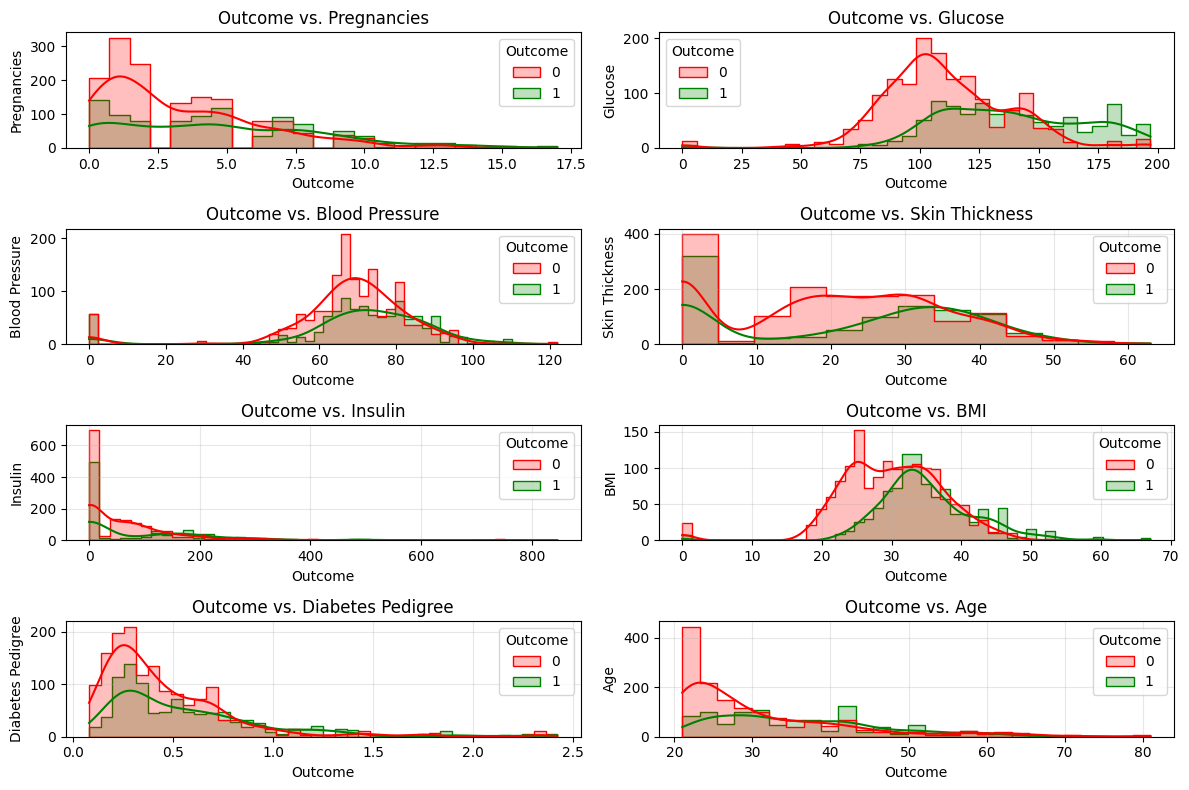

In [22]:
# Create subplots
fig, axes = plt.subplots(4, 2, figsize=(12, 8))

# Plot Outcome vs. Pregnancies
sns.histplot(ax=axes[0,0], data=data, x='Pregnancies', hue='Outcome', kde=True, element='step', palette=['red', 'green'])
axes[0, 0].set_xlabel('Outcome')
axes[0, 0].set_ylabel('Pregnancies')
axes[0, 0].set_title('Outcome vs. Pregnancies')

# Plot Outcome vs. Glucose
sns.histplot(ax=axes[0,1], data=data, x='Glucose', hue='Outcome', kde=True, element='step', palette=['red', 'green'])
axes[0, 1].set_xlabel('Outcome')
axes[0, 1].set_ylabel('Glucose')
axes[0, 1].set_title('Outcome vs. Glucose')

# Plot Outcome vs. BloodPressure
sns.histplot(ax=axes[1,0], data=data, x='BloodPressure', hue='Outcome', kde=True, element='step', palette=['red', 'green'])
axes[1, 0].set_xlabel('Outcome')
axes[1, 0].set_ylabel('Blood Pressure')
axes[1, 0].set_title('Outcome vs. Blood Pressure')

# Plot Outcome vs. SkinThickness
sns.histplot(ax=axes[1,1], data=data, x='SkinThickness', hue='Outcome', kde=True, element='step', palette=['red', 'green'])
axes[1, 1].set_xlabel('Outcome')
axes[1, 1].set_ylabel('Skin Thickness')
axes[1, 1].set_title('Outcome vs. Skin Thickness')
axes[1, 1].grid(alpha=0.3)

# Plot Outcome vs. Insulin
sns.histplot(ax=axes[2,0], data=data, x='Insulin', hue='Outcome', kde=True, element='step', palette=['red', 'green'])
axes[2, 0].set_xlabel('Outcome')
axes[2, 0].set_ylabel('Insulin')
axes[2, 0].set_title('Outcome vs. Insulin')
axes[2, 0].grid(alpha=0.3)

# Plot Outcome vs. BMI
sns.histplot(ax=axes[2,1], data=data, x='BMI', hue='Outcome', kde=True, element='step', palette=['red', 'green'])
axes[2, 1].set_xlabel('Outcome')
axes[2, 1].set_ylabel('BMI')
axes[2, 1].set_title('Outcome vs. BMI')
axes[2, 1].grid(alpha=0.3)

# Plot Outcome vs. DiabetesPedigreeFunction
sns.histplot(ax=axes[3,0], data=data, x='DiabetesPedigreeFunction', hue='Outcome', kde=True, element='step', palette=['red', 'green'])
axes[3, 0].set_xlabel('Outcome')
axes[3, 0].set_ylabel('Diabetes Pedigree')
axes[3, 0].set_title('Outcome vs. Diabetes Pedigree')
axes[3, 0].grid(alpha=0.3)

# Plot Outcome vs. Age
sns.histplot(ax=axes[3,1], data=data, x='Age', hue='Outcome', kde=True, element='step', palette=['red', 'green'])
axes[3, 1].set_xlabel('Outcome')
axes[3, 1].set_ylabel('Age')
axes[3, 1].set_title('Outcome vs. Age')
axes[3, 1].grid(alpha=0.3)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

In [26]:
data['SkinThickness'].value_counts()[0]

717

In [27]:
data['Insulin'].value_counts()[0]

1181

Generally speaking, diabetes diagnosis seems more common at the high (right) ends of many of these features, particularly glucose level and BMI. There is enough of a relationship to warrant testing all predictors in our models.

Both skin thickness and insulin have a large presence of 0 as a value, which seems to mean null. As a result, they may worsen the performance of the model, so we will try with and without these columns.

In [ ]:
# Define predictors and response variable
X = data[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']]
y = data['Outcome']

In [30]:
# Create training and testing sets, with 80-20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale predictors
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

### Logistic Regression

In [31]:
# Instantiate the logistic regression model
lr_model = LogisticRegression(max_iter=1000)

# Train the model on the training set
lr_model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [32]:
# Predict probabilities and classes
lr_y_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]
lr_y_pred = lr_model.predict(X_test_scaled)

In [39]:
# Confusion matrix
lr_cm = confusion_matrix(y_test, lr_y_pred)
lr_cm

array([[260,  45],
       [ 89,  98]])

### k-NN

In [38]:
# Covariance matrix for Mahalanobis distance
cov = np.cov(X_train_scaled, rowvar=False)

# Parameter grid for other metrics
param_grid = {
    'n_neighbors': list(range(1,31,2)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev'],
    'algorithm': ['auto']
}

# Create standard KNN model
knn = KNeighborsClassifier()

# Perform grid search
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='precision', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['auto'],
                         'metric': ['euclidean', 'manhattan', 'chebyshev'],
                         'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29],
                         'weights': ['uniform', 'distance']},
             scoring='precision')

In [40]:
# Get best parameters and score
standard_best_params = grid_search.best_params_
standard_best_score = grid_search.best_score_
print(f"Best parameters (standard metrics): {standard_best_params}")
print(f"Best cross-validation accuracy: {standard_best_score:.4f}")

Best parameters (standard metrics): {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
Best cross-validation accuracy: 0.9911


In [41]:
# Mahalanobis
# Create a custom object to include covariance matrix as special parameter
knn_mahalanobis = KNeighborsClassifier(metric='mahalanobis', metric_params={'VI': cov})

# Parameters for Mahalanobis
param_grid_mahalanobis = {
   'n_neighbors': list(range(1, 31, 2)),
   'weights': ['uniform', 'distance'],
   'algorithm': ['auto']
}

# Perform grid search for Mahalanobis
print("\nStarting grid search for Mahalanobis metric...")
grid_search_mahalanobis = GridSearchCV(knn_mahalanobis, param_grid_mahalanobis, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_mahalanobis.fit(X_train_scaled, y_train)


Starting grid search for Mahalanobis metric...


GridSearchCV(cv=5,
             estimator=KNeighborsClassifier(metric='mahalanobis',
                                            metric_params={'VI': array([[ 1.00050839,  0.18384863,  0.11705413, -0.01307308, -0.03959691,
         0.10774872, -0.05204733,  0.53846737],
       [ 0.18384863,  1.00050839,  0.11900316,  0.059243  ,  0.36162855,
         0.25872872,  0.16884584,  0.26724548],
       [ 0.11705413,  0.11900316,  1.00050839,  0.20955844,  0.09705351,
         0.24511422,  0.006...
         1.00050839,  0.12373139,  0.0728176 ],
       [-0.05204733,  0.16884584,  0.0062259 ,  0.17546884,  0.24628067,
         0.12373139,  1.00050839,  0.04392786],
       [ 0.53846737,  0.26724548,  0.20914535, -0.11853036, -0.01577956,
         0.0728176 ,  0.04392786,  1.00050839]])}),
             n_jobs=-1,
             param_grid={'algorithm': ['auto'],
                         'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [42]:
# Get best parameters and score
mahalanobis_best_params = grid_search_mahalanobis.best_params_
mahalanobis_best_score = grid_search_mahalanobis.best_score_
print(f"Best parameters (Mahalanobis): {mahalanobis_best_params}")
print(f"Best cross-validation accuracy: {mahalanobis_best_score:.4f}")

Best parameters (Mahalanobis): {'algorithm': 'auto', 'n_neighbors': 17, 'weights': 'distance'}
Best cross-validation accuracy: 0.9934


In [44]:
# Determine overall best model
best_scores = {
    'Standard': (standard_best_score, standard_best_params),
    'Mahalanobis': (mahalanobis_best_score, mahalanobis_best_params)
}

best_model_type = max(best_scores, key=lambda k: best_scores[k][0])
best_score = best_scores[best_model_type][0]
best_params = best_scores[best_model_type][1]

print(f"\nOverall best model: {best_model_type}")
print(f"Best parameters: {best_params}")
print(f"Best cross-validation accuracy: {best_score:.4f}")


Overall best model: Mahalanobis
Best parameters: {'algorithm': 'auto', 'n_neighbors': 17, 'weights': 'distance'}
Best cross-validation accuracy: 0.9934


### Decision Tree

In [47]:
# Create and train the decision tree
# Instantiate model
dt_model = DecisionTreeClassifier(
   max_depth=3,
   min_samples_leaf=2,
   random_state=42
)

# Train the model
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=2, random_state=42)

Model Precision: 0.90


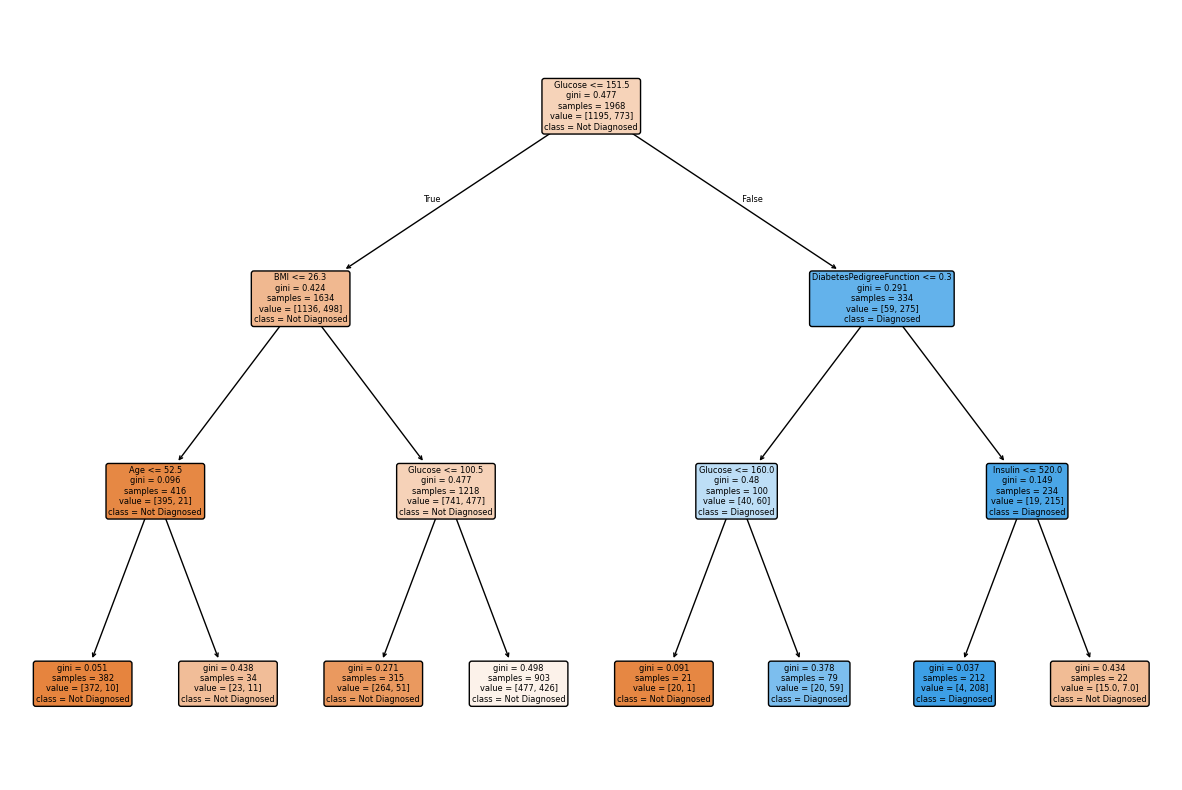


Feature Importance:
                    feature  importance
1                   Glucose    0.657597
5                       BMI    0.225779
4                   Insulin    0.054805
6  DiabetesPedigreeFunction    0.044548
7                       Age    0.017271
0               Pregnancies    0.000000
2             BloodPressure    0.000000
3             SkinThickness    0.000000

Feature: Pregnancies
Importance Score: 0.000
Used in 0 nodes

Feature: Glucose
Importance Score: 0.658
Used in 3 nodes

Feature: BloodPressure
Importance Score: 0.000
Used in 0 nodes

Feature: SkinThickness
Importance Score: 0.000
Used in 0 nodes

Feature: Insulin
Importance Score: 0.055
Used in 1 nodes

Feature: BMI
Importance Score: 0.226
Used in 1 nodes

Feature: DiabetesPedigreeFunction
Importance Score: 0.045
Used in 1 nodes

Feature: Age
Importance Score: 0.017
Used in 1 nodes


In [49]:
# Make predictions
dt_y_pred = dt_model.predict(X_test) #try X_test_scaled

dt_precision = precision_score(y_test, dt_y_pred)
print(f"Model Precision: {dt_precision:.2f}")

# Visualize the tree
plt.figure(figsize=(15,10))
plot_tree(dt_model, 
          feature_names=X.columns,
          class_names=['Not Diagnosed', 'Diagnosed'],
          filled=True,
          rounded=True)
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Extract feature importance from model and align with feature columns
for feature, importance in zip(X.columns, dt_model.feature_importances_):
   n_nodes = sum([1 for i in range(dt_model.tree_.node_count)
                  if dt_model.tree_.feature[i] == X.columns.get_loc(feature)])
  
   print(f"\nFeature: {feature}")
   print(f"Importance Score: {importance:.3f}")
   print(f"Used in {n_nodes} nodes")

### Random Forest

### XGBoost